In [208]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pickle # for hacky deep copy
import random

In [209]:
RANDOM = True
rows_count = 10
columns_count = 10

if (random):
    start_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
    
    terminating = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]    
    while(terminating==start_position):
        terminating = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
        
    key_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
    while((key_position==terminating)or(key_position==start_position)):
        key_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
else:
    start_position = [(0,0)]
    terminating = [(9,9)]
    key_position = [(0,8)]
                         
                         
                        
DOOR = "D"
START = "S"
EMPTY = "E"
WALL = "W"
KEY = "K"
PATH = "P"
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
stepcost = -1

def generateTestMaze():
    V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    V.fillna(EMPTY, inplace=True)
    V.iloc[0][1] = WALL
    V.iloc[1][1] = WALL
    V.iloc[2][1] = WALL
    
    V.iloc[1][3] = WALL
    V.iloc[1][5] = WALL
    V.iloc[1][6] = WALL
    
    V.iloc[4][0] = WALL
    V.iloc[4][1] = WALL
    V.iloc[4][2] = WALL
    V.iloc[4][3] = WALL
    
    V.iloc[7][0] = WALL
    V.iloc[7][1] = WALL
    V.iloc[7][2] = WALL
    V.iloc[7][4] = WALL
    V.iloc[7][5] = WALL
    V.iloc[7][6] = WALL
    
    V.iloc[0][7] = WALL
    V.iloc[1][7] = WALL
    V.iloc[2][7] = WALL
    V.iloc[3][7] = WALL
    V.iloc[6][7] = WALL
    
    V.iloc[4][8] = WALL
    V.iloc[5][8] = WALL
    
    V.iloc[key_position[0][0]][key_position[0][1]] = KEY
    V.iloc[terminating[0][0]][terminating[0][1]] = DOOR
    V.iloc[start_position[0][0]][start_position[0][1]] = START
    return V
    

maze = generateTestMaze()
print(maze)

   0  1  2  3  4  5  6  7  8  9
0  E  W  E  E  E  E  E  W  E  E
1  E  W  E  W  E  W  W  S  E  E
2  E  W  E  E  E  E  E  W  E  E
3  E  E  E  E  E  D  E  W  E  E
4  W  W  W  W  E  E  E  E  W  E
5  E  E  E  E  E  E  E  E  W  E
6  E  E  E  E  E  E  E  W  E  E
7  W  W  W  E  W  W  W  E  E  K
8  E  E  E  E  E  E  E  E  E  E
9  E  E  E  E  E  E  E  E  E  E


(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

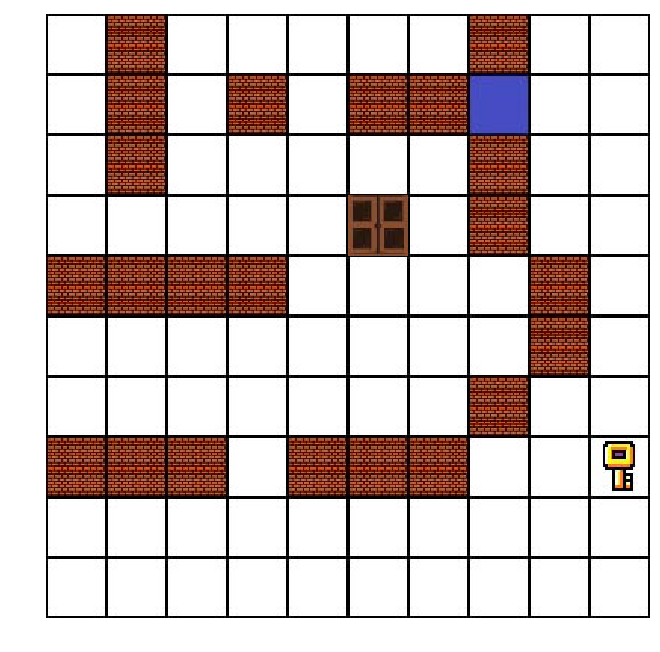

In [210]:
def arrayToImage(array, ncols=10):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


def makeImageArray(start, dataframe):
    imageArray = np.array([np.asarray(Image.open('images/empty.jpg').convert('RGB'))])
    for i in range(rows_count):
        for j in range(columns_count):
            #skip the first cell, since we already add it in the begining
            if (i!=0) or (j!=0):                
                path = "images/empty.jpg"
                if dataframe.iloc()[i][j] == WALL:
                    path = "images/wall.jpg"
                elif dataframe.iloc()[i][j] == DOOR:
                    path = "images/door.jpg"
                elif dataframe.iloc()[i][j] == PATH:
                    path = "images/path.jpg"
                elif dataframe.iloc()[i][j] == KEY:
                    path = "images/key.jpg"
                imageArray = np.append(imageArray, [np.asarray(Image.open(path).convert('RGB'))], axis=0)  
    
    path = "images/path.jpg"
    imageArray[start[0][0]*rows_count+start[0][1]] = np.asarray(Image.open(path).convert('RGB'))
    return imageArray

def showMaze(array):
    print(array.shape)
    result = arrayToImage(array)
    plt.figure(2)
    fig=plt.figure(figsize=(8, 8), dpi = 100)
    plt.imshow(result)
    plt.axis('off')    
    plt.show()        

array = makeImageArray(start_position, maze)
showMaze(array)

In [211]:
def epsilon_greedy(Q, epsilon, row, column):
    if np.random.rand() < epsilon:
        actIndex = Q.iloc()[row][column].index(max(Q.iloc()[row][column]))        
    else:
        actIndex = random.choice([UP, DOWN, LEFT, RIGHT])    
    
    return actIndex

def valueForMaze(row, column, action, maze, ending): 
    """
    @param row
    @param column
    @param action
    @param maze
    
    Make sure that the action don't make you step out of the array bondary [0, rows_count-1] or [0, columns_count-1]
    Some codes look like it doesn't do anything (actionColumn = max(column, 0)), but it actually does something
    in other scenario (column was change because of "Wind blow left", so just leave it there)
    """
    if (row,column) in ending:
        return 0, 0, 0    
    else:        
        if (action == UP):
            actionRow = max(min(row-1, rows_count-1), 0)
            actionColumn = max(min(column, columns_count-1),0)
        elif (action == DOWN) :
            actionRow = max(min(row+1, rows_count-1),0)
            actionColumn = max(min(column, columns_count-1),0)
        elif (action == LEFT) :
            actionRow = max(min(row, rows_count-1),0)
            actionColumn = max(column-1, 0)
        elif (action == RIGHT) :
            actionRow = max(min(row, rows_count-1),0)
            actionColumn = max(min(column+1, columns_count-1),0)
        
        #Check if step into wall
        if (maze.iloc()[actionRow][actionColumn]) == "W":
            return stepcost, row, column
        else:
            return stepcost, actionRow, actionColumn

def training(rows_count, columns_count, episode, maxStep, start, ending, epsilon, gamma, alpha, maze):
    #Initialize Q(s,a):
    random.seed(2705)
    Q = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    for i in range(rows_count):
        for j in range (columns_count):
            Q.iloc()[i][j] = [0, 0, 0, 0]
    
    for i in tqdm(range(episode)):
        #initialize stage S:
        #row = random.randint(0, rows_count-1)
        #column = random.randint(0, columns_count-1)
        row = start[0][0]
        column = start[0][1]

        #If the result is wall, do it again
        """
        while (maze.iloc()[row][column] == "W"):
            row = random.randint(0, rows_count-1)
            column = random.randint(0, columns_count-1)                            
        """

        step = 1
        if (i<0.2*episode): epsilon = 0.1
        if (i<0.4*episode): epsilon = 0.3
        if (i<0.6*episode): epsilon = 0.5
        if (i<0.8*episode): epsilon = 0.8
        
        #Choose action A from state S using policy derived from Q (e.g., epsilon-greedy)
        action = epsilon_greedy(Q, epsilon, row, column)

        while(step < maxStep):
            #Until S is terminal
            if (row,column) in ending:
                break

            #Take action A, observe R (reward) and new state S':
            reward, newRow, newColumn = valueForMaze(row, column, action, maze, ending)

            #Choose action A' from state S' using policy derived from Q (e.g., epsilon-greedy)
            newAction = epsilon_greedy(Q, epsilon, newRow, newColumn)        

            #Q(S,A) <- Q(S,A) + alpha*[R + gamma*Q(S',A') - Q(S,A)]
            Q.iloc()[row][column][action] = Q.iloc()[row][column][action] +\
                alpha*(reward + gamma*Q.iloc()[newRow][newColumn][newAction] - Q.iloc()[row][column][action])
            row = newRow
            column = newColumn
            action = newAction
            step+=1

    return Q


In [212]:
gamma = 1
alpha = 0.2
episode = 400
maxStep = 300
epsilon = 0.4

Qkey = training(rows_count, columns_count, episode, maxStep, start_position, key_position, epsilon, gamma, alpha, maze)

100%|██████████| 400/400 [00:08<00:00, 49.72it/s]


In [213]:
gamma = 1
alpha = 0.2
episode = 400
maxStep = 300
epsilon = 0.4

Qdoor = training(rows_count, columns_count, episode, maxStep, key_position, terminating, epsilon, gamma, alpha, maze)

100%|██████████| 400/400 [00:23<00:00, 16.95it/s]


In [214]:
def generateResultMaze(qDF, baseMaze, start, ending):
    myMaze = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    myMaze.fillna(EMPTY, inplace=True)
    row = start[0][0]
    column = start[0][1]
    myMaze.iloc()[row][column] = PATH
    
    maxLength = rows_count*columns_count*10
    step = 0
    
    #Put in the correct path
    while (((row,column) not in ending) and (step < maxLength)):
        actIndex = qDF.iloc()[row][column].index(max(qDF.iloc()[row][column]))        
        if (actIndex == 0):
            row = max(row - 1, 0)
        elif (actIndex == 1):
            row = row + 1
        elif (actIndex == 2):
            column = max(column - 1, 0)
        else:
            column = min(column + 1, columns_count-1)
        myMaze.iloc()[row][column] = PATH
        step = step + 1
        if (step==maxLength):
            print("Failed to find the exit after walk for {} times".format(step))
    
    #Put in the wall
    for i in range(rows_count):
        for j in range (columns_count):
            if (baseMaze.iloc()[i][j] == WALL):
                myMaze.iloc()[i][j] = WALL
            if (baseMaze.iloc()[i][j] == DOOR):
                myMaze.iloc()[i][j] = DOOR
            if (baseMaze.iloc()[i][j] == KEY):
                myMaze.iloc()[i][j] = KEY
                
    return myMaze

In [215]:
ACTION_LIST = ["UP", "DOWN", "LEFT", "RIGHT"]
print("-------------------------GO TO KEY-----------------------------")
print(" ")
V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))

for i in range(rows_count):
    for j in range (columns_count):
        actIndex = Qkey.iloc()[i][j].index(max(Qkey.iloc()[i][j]))
        V.iloc()[i][j] = ACTION_LIST[actIndex]

V.iloc()[start_position[0][0]][start_position[0][1]] = "-| |-"            
V.iloc()[key_position[0][0]][key_position[0][1]] = "--X--"    
print(V)
print(" ")
print("-------------------------GO TO DOOR-----------------------------")
print(" ")
V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
for i in range(rows_count):
    for j in range (columns_count):
        actIndex = Qdoor.iloc()[i][j].index(max(Qdoor.iloc()[i][j]))
        V.iloc()[i][j] = ACTION_LIST[actIndex]

V.iloc()[key_position[0][0]][key_position[0][1]] = "-| |-"    
V.iloc()[terminating[0][0]][terminating[0][1]] = "--X--"    
print(V)

-------------------------GO TO KEY-----------------------------
 
       0      1      2      3      4      5      6      7      8      9
0   LEFT     UP  RIGHT  RIGHT   LEFT     UP     UP     UP  RIGHT   DOWN
1     UP     UP     UP     UP   LEFT     UP     UP  -| |-   DOWN   DOWN
2  RIGHT     UP  RIGHT  RIGHT  RIGHT   LEFT   LEFT     UP   DOWN   DOWN
3     UP     UP     UP  RIGHT  RIGHT   LEFT  RIGHT     UP  RIGHT   DOWN
4     UP     UP     UP     UP  RIGHT  RIGHT   LEFT     UP     UP   DOWN
5   DOWN   DOWN   LEFT  RIGHT   LEFT     UP   LEFT     UP     UP   DOWN
6   DOWN   LEFT   LEFT   LEFT  RIGHT   DOWN     UP     UP   DOWN   DOWN
7     UP     UP     UP     UP     UP     UP     UP   LEFT  RIGHT  --X--
8   DOWN   LEFT     UP   LEFT   LEFT     UP   DOWN  RIGHT   LEFT  RIGHT
9  RIGHT  RIGHT   LEFT   LEFT  RIGHT     UP  RIGHT  RIGHT  RIGHT     UP
 
-------------------------GO TO DOOR-----------------------------
 
       0      1      2      3      4      5     6      7      8      9
0 

(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

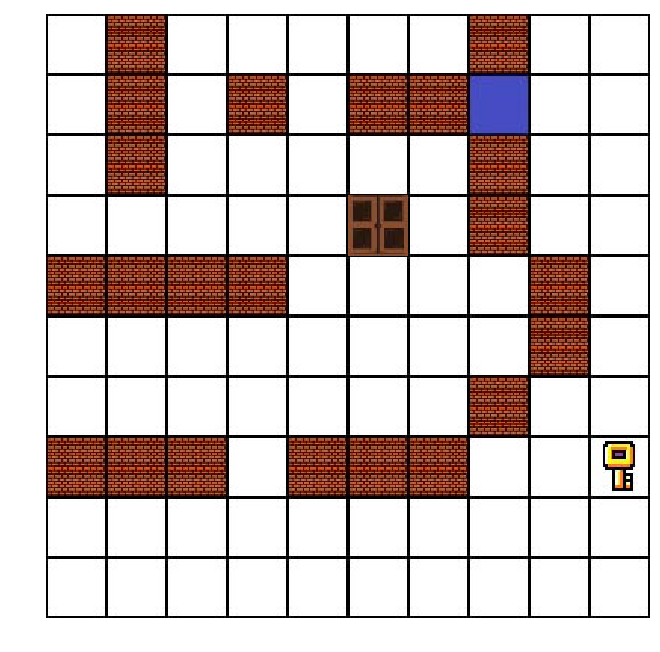

In [216]:
array = makeImageArray(start_position, maze)
showMaze(array)

(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

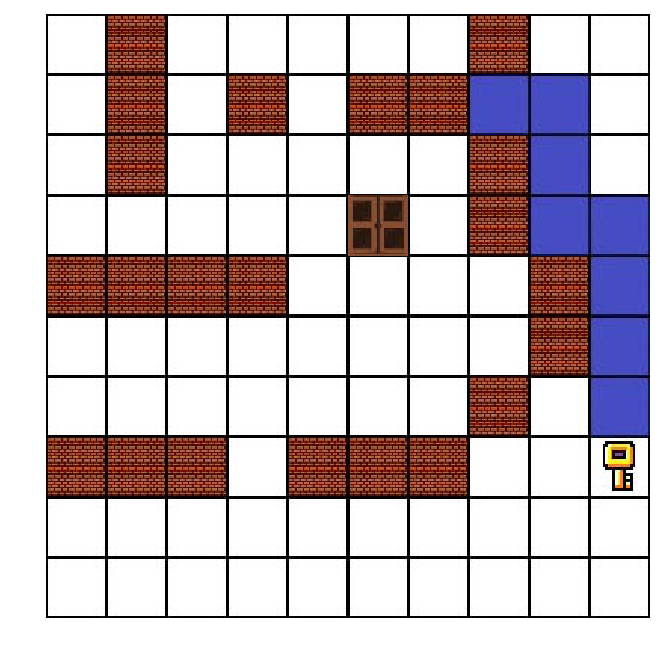

(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

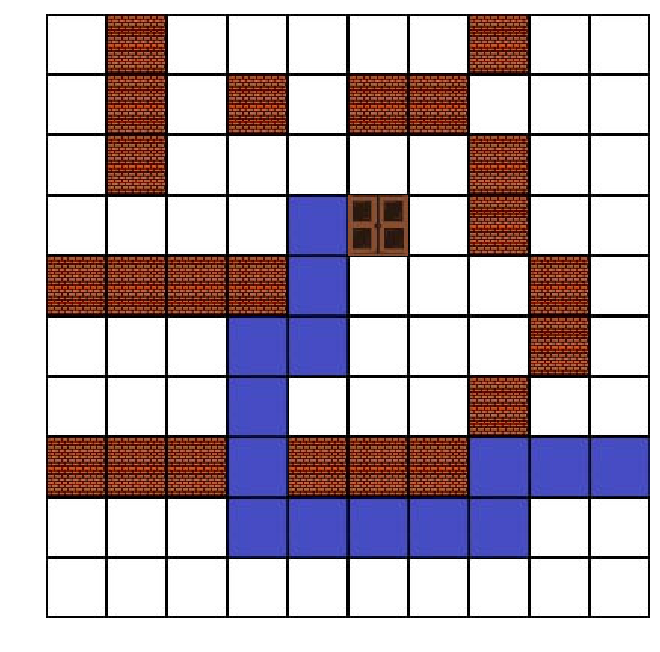

In [217]:
mazeKey = generateResultMaze(Qkey, maze, start_position, key_position)
resultKey = makeImageArray(start_position, mazeKey)
showMaze(resultKey)

mazeDoor = generateResultMaze(Qdoor, maze, key_position, terminating)
resultDoor = makeImageArray(key_position, mazeDoor)
showMaze(resultDoor)